# Import packages

In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 500)
from scipy.stats import levy_stable

from datetime import datetime
from scipy.stats import kstest
from scipy.stats import jarque_bera
# from arch.unitroot import ADF
from scipy.stats import kurtosis
from scipy.stats import skew
# from arch import arch_model

import pickle

import ta

import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import webbrowser
from datetime import datetime, timedelta

import random

plt.style.use('classic')
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.max_rows', 300)

# %config inlinebackend.figure_format = 'svg'

In [2]:
import sys

sys.path.insert(0, 'D:/Intraday_trading')

In [3]:
from src.support import *
from src.backtest import *
from src.models import *
from src.models_support import *

# Import and pre-processing data

## Interval data

In [4]:
interval_data = pd.read_pickle('D:/Intraday_trading/Training/Data/XAUUSD_M15_1.pkl')

interval_data = interval_data.set_index('DATE_TIME')
interval_data.index = pd.to_datetime(interval_data.index)

interval_data['DATE'] = pd.to_datetime(interval_data['DATE'])
interval_data['OPEN'] = interval_data['OPEN']
interval_data['HIGH'] = interval_data['HIGH']
interval_data['LOW'] = interval_data['LOW']
interval_data['CLOSE'] = interval_data['CLOSE']


### Prepare_df

In [5]:
df_4_hour = prepare_df(df = interval_data, timeframe = '4H', add_indicators = True)
df_1_day = prepare_df(df = interval_data, timeframe = '1D', add_indicators = True)
df_15_min = prepare_df(df = interval_data, timeframe = '15min', add_indicators = True)

df_1_day['WHOLE_RANGE'] = df_1_day['HIGH'] - df_1_day['LOW']
df_4_hour['WHOLE_RANGE'] = df_4_hour['HIGH'] - df_4_hour['LOW']
df_15_min['WHOLE_RANGE'] = df_15_min['HIGH'] - df_15_min['LOW']

df_1_day['GRP_WHOLE_RANGE'] = pd.qcut(df_1_day['WHOLE_RANGE'], 10)
df_4_hour['GRP_WHOLE_RANGE'] = pd.qcut(df_4_hour['WHOLE_RANGE'], 10)
df_15_min['GRP_WHOLE_RANGE'] = pd.qcut(df_15_min['WHOLE_RANGE'], 10)

df_1_day['GRP_BODY'] = pd.qcut(df_1_day['BODY'], 10)
df_4_hour['GRP_BODY'] = pd.qcut(df_4_hour['BODY'], 10)
df_15_min['GRP_BODY'] = pd.qcut(df_15_min['BODY'], 10)

df_1_day['YEAR'] = df_1_day.index.strftime('%Y')
df_1_day['WEEK'] = df_1_day.index.strftime('%Y%W')
df_1_day['MONTH'] = df_1_day.index.strftime('%Y%m')

df_4_hour['YEAR'] = df_4_hour.index.strftime('%Y')
df_4_hour['WEEK'] = df_4_hour.index.strftime('%Y%W')
df_4_hour['MONTH'] = df_4_hour.index.strftime('%Y%m')

df_15_min['YEAR'] = df_15_min.index.strftime('%Y')
df_15_min['WEEK'] = df_15_min.index.strftime('%Y%W')
df_15_min['MONTH'] = df_15_min.index.strftime('%Y%m')



In [6]:
df_15_min.shape, df_4_hour.shape, df_1_day.shape, 

((99741, 36), (6783, 36), (1311, 36))

In [7]:
df_1_day.columns

Index(['OPEN', 'HIGH', 'LOW', 'CLOSE', 'TICK_VOL', 'AVG_PRICE',
       'FLAG_INCREASE_CANDLE', 'BODY', 'UPPER_SHADOW', 'LOWER_SHADOW',
       'WHOLE_RANGE', 'FLAG_LONG_UPPER_SHADOW', 'FLAG_LONG_LOWER_SHADOW',
       'FLAG_HIGHER_HIGH(20)', 'FLAG_HIGHER_LOW(20)', 'AVG_VOL(50)',
       'FLAG_OVER_AVG_VOL(50)', 'AVG_VOL(200)', 'FLAG_OVER_AVG_VOL(200)',
       'FLAG_UPTREND_VOL(20)', 'RSI', 'FLAG_UNDER_30_RSI', 'FLAG_OVER_70_RSI',
       'FLAG_UPTREND_RSI(20)', 'BB_UPPER_BAND(50)', 'BB_LOWER_BAND(50)',
       'EMA(50)', 'POSITION_EMA(50)', 'EMA(200)', 'POSITION_EMA(200)',
       'Ret(t)', 'GRP_WHOLE_RANGE', 'GRP_BODY', 'YEAR', 'WEEK', 'MONTH'],
      dtype='object')

In [8]:
# df_15_min.index[0], df_15_min.index[-1]

In [9]:
# plot_df(df_1_day, 
#         path = None,# 'D:/Intraday_trading/Training/Saved_results/plot_df.html', 
#         open_tab = False)

# Strategy

In [10]:
interval_is = interval_data[interval_data.index < datetime(2023, 1, 1)]
interval_os = interval_data[interval_data.index >= datetime(2023, 1, 1)]


In [11]:
df_4_hour_is = prepare_df(df = interval_is, timeframe = '4H', add_indicators = False)
df_1_day_is = prepare_df(df = interval_is, timeframe = '1D', add_indicators = False)
df_15_min_is = prepare_df(df = interval_is, timeframe = '15min', add_indicators = False)

df_1_day_is['WHOLE_RANGE'] = df_1_day_is['HIGH'] - df_1_day_is['LOW']
df_4_hour_is['WHOLE_RANGE'] = df_4_hour_is['HIGH'] - df_4_hour_is['LOW']
df_15_min_is['WHOLE_RANGE'] = df_15_min_is['HIGH'] - df_15_min_is['LOW']

df_1_day_is['GRP_WHOLE_RANGE'] = pd.qcut(df_1_day_is['WHOLE_RANGE'], 10)
df_4_hour_is['GRP_WHOLE_RANGE'] = pd.qcut(df_4_hour_is['WHOLE_RANGE'], 10)
df_15_min_is['GRP_WHOLE_RANGE'] = pd.qcut(df_15_min_is['WHOLE_RANGE'], 10)

df_1_day_is['GRP_BODY'] = pd.qcut(df_1_day_is['BODY'], 10)
df_4_hour_is['GRP_BODY'] = pd.qcut(df_4_hour_is['BODY'], 10)
df_15_min_is['GRP_BODY'] = pd.qcut(df_15_min_is['BODY'], 10)

df_1_day_is['YEAR'] = df_1_day_is.index.strftime('%Y')
df_1_day_is['WEEK'] = df_1_day_is.index.strftime('%Y%W')
df_1_day_is['MONTH'] = df_1_day_is.index.strftime('%Y%m')
df_1_day_is['DATE'] = df_1_day_is.index.strftime('%Y%m%d')

df_4_hour_is['YEAR'] = df_4_hour_is.index.strftime('%Y')
df_4_hour_is['WEEK'] = df_4_hour_is.index.strftime('%Y%W')
df_4_hour_is['MONTH'] = df_4_hour_is.index.strftime('%Y%m')
df_4_hour_is['DATE'] = df_4_hour_is.index.strftime('%Y%m%d')

df_15_min_is['YEAR'] = df_15_min_is.index.strftime('%Y')
df_15_min_is['WEEK'] = df_15_min_is.index.strftime('%Y%W')
df_15_min_is['MONTH'] = df_15_min_is.index.strftime('%Y%m')
df_15_min_is['DATE'] = df_15_min_is.index.strftime('%Y%m%d')

#-----------------------------------------------------

df_4_hour_os = prepare_df(df = interval_os, timeframe = '4H', add_indicators = False)
df_1_day_os = prepare_df(df = interval_os, timeframe = '1D', add_indicators = False)
df_15_min_os = prepare_df(df = interval_os, timeframe = '15min', add_indicators = False)

df_1_day_os['WHOLE_RANGE'] = df_1_day_os['HIGH'] - df_1_day_os['LOW']
df_4_hour_os['WHOLE_RANGE'] = df_4_hour_os['HIGH'] - df_4_hour_os['LOW']
df_15_min_os['WHOLE_RANGE'] = df_15_min_os['HIGH'] - df_15_min_os['LOW']

df_1_day_os['GRP_WHOLE_RANGE'] = pd.qcut(df_1_day_os['WHOLE_RANGE'], 10)
df_4_hour_os['GRP_WHOLE_RANGE'] = pd.qcut(df_4_hour_os['WHOLE_RANGE'], 10)
df_15_min_os['GRP_WHOLE_RANGE'] = pd.qcut(df_15_min_os['WHOLE_RANGE'], 10)

df_1_day_os['GRP_BODY'] = pd.qcut(df_1_day_os['BODY'], 10)
df_4_hour_os['GRP_BODY'] = pd.qcut(df_4_hour_os['BODY'], 10)
df_15_min_os['GRP_BODY'] = pd.qcut(df_15_min_os['BODY'], 10)

df_1_day_os['YEAR'] = df_1_day_os.index.strftime('%Y')
df_1_day_os['WEEK'] = df_1_day_os.index.strftime('%Y%W')
df_1_day_os['MONTH'] = df_1_day_os.index.strftime('%Y%m')

df_4_hour_os['YEAR'] = df_4_hour_os.index.strftime('%Y')
df_4_hour_os['WEEK'] = df_4_hour_os.index.strftime('%Y%W')
df_4_hour_os['MONTH'] = df_4_hour_os.index.strftime('%Y%m')

df_15_min_os['YEAR'] = df_15_min_os.index.strftime('%Y')
df_15_min_os['WEEK'] = df_15_min_os.index.strftime('%Y%W')
df_15_min_os['MONTH'] = df_15_min_os.index.strftime('%Y%m')


In [12]:
df_1_day_is.shape, df_1_day_os.shape

((620, 27), (691, 26))

## In sample optimization

In [13]:
config = {
    'RSI_PARAMS': {'INPUT_PARAM': 7, 'CUTOFF_BUY': 30, 'CUTOFF_SELL': 70},
    'BB_PARAMS': {'INPUT_MEAN': 50, 'INPUT_SD': 2, 'BB_CUTOFF': 3},
    'EMA_1_PARAMS': {'INPUT_PARAM': 50},
    'EMA_2_PARAMS': {'INPUT_PARAM': 200},
    'WEIGHT_DAILY': 3,
    'WEIGHT_4HOUR': 2,
    'WEIGHT_15MIN': 2,
    'LOOKBACK': 20,
    'base_SL': 10, 
    'base_TP': 20,
    'DECISION_CUTOFF': {'ENTRY_BUY_CUTOFF': 0.2, 'ENTRY_SELL_CUTOFF': 0.2}
}

extra_params = {
    'df_1_day_is': df_1_day_is, 
    'df_4_hour_is': df_4_hour_is, 
    'df_15_min_is': df_15_min_is
}

alpha = TA_strat_v1(config = config, extra_params = extra_params)

In [15]:
# config = {
#     'RSI_PARAMS': {'INPUT_PARAM': 7, 'CUTOFF_BUY': 30, 'CUTOFF_SELL': 70},
#     'base_SL': 10, 
#     'base_TP': 20,
# }

# extra_params = {}

# alpha = RSI_strat(config = config)

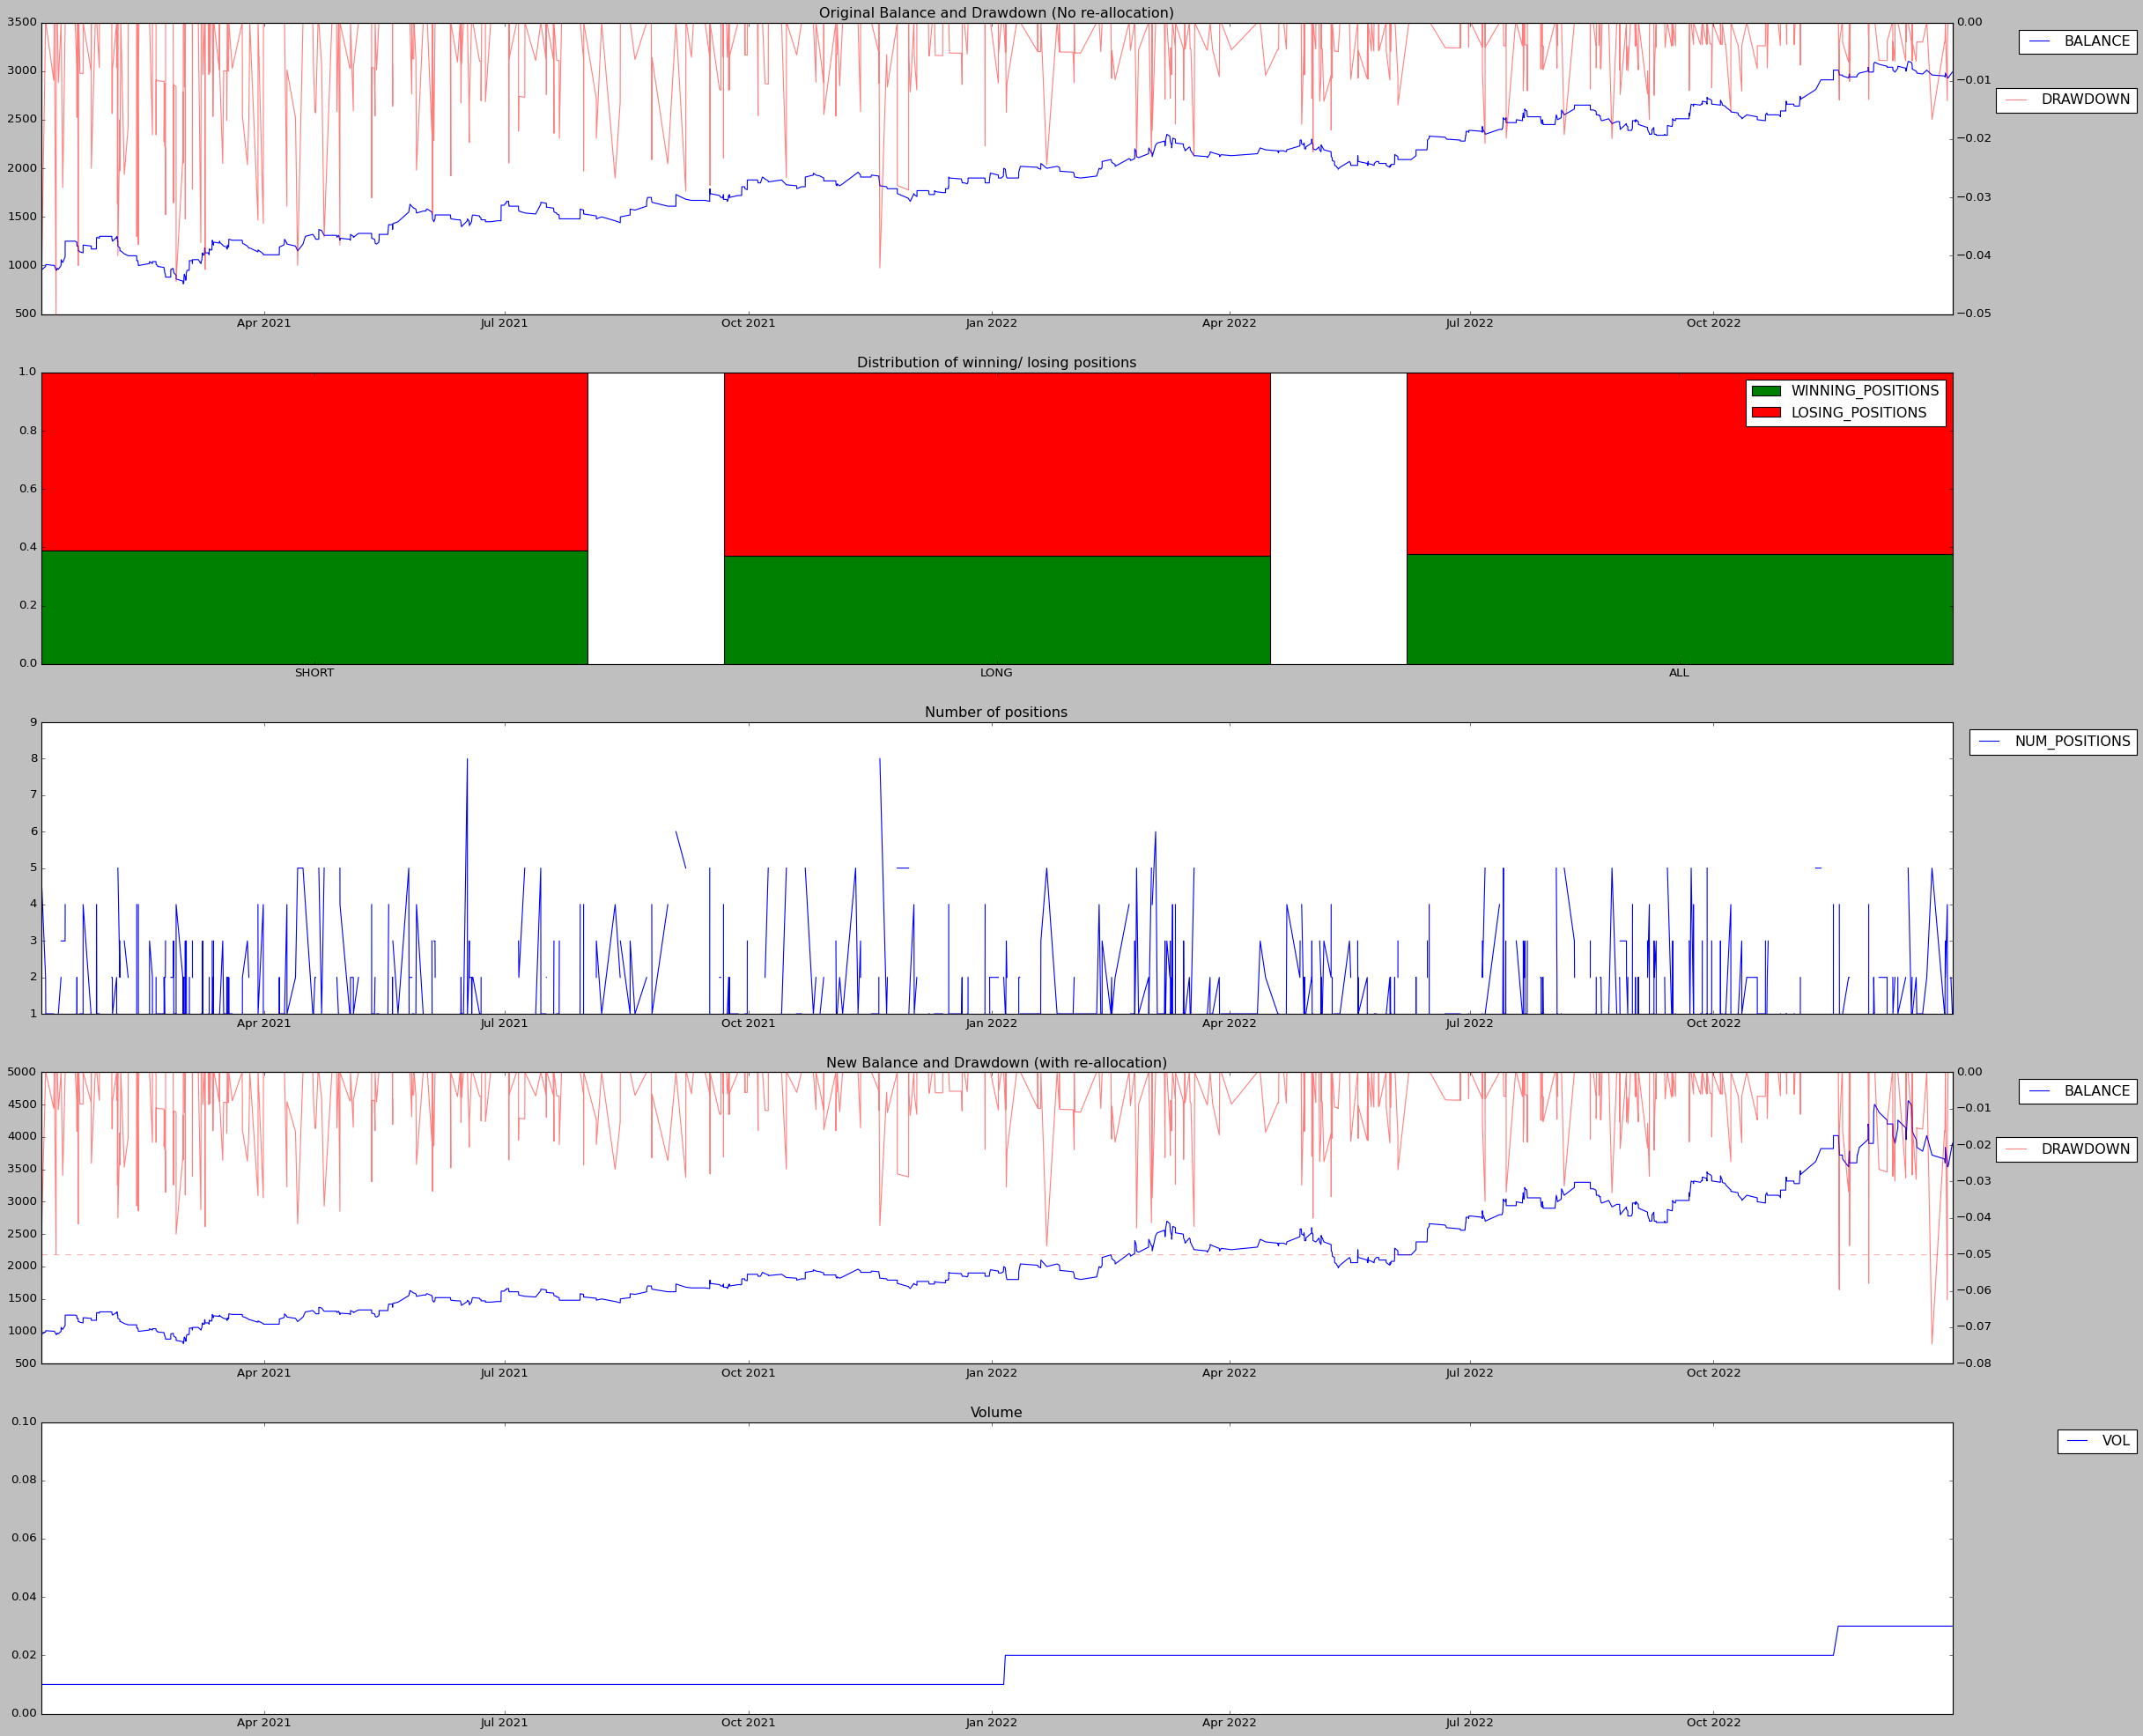

In [16]:
report_is = Backtest_report(alpha = alpha,
                            df_is = df_15_min_is.copy(),
                            base_SL = 10,
                            base_TP = 20,
                            max_existing_positions = 5,
                            init_vol = 0.01,
                            re_allocation = True,
                            incre_vol = 0.01,
                            max_vol = 0.1,
                            init_cap = 1000,
                            incre_cap = 2
                            )

report_is.display_report()

In [17]:
# report_is.prepare_report()

In [18]:
df_result_is = report_is.df_result_is
df_balance_is = report_is.df_balance_is
df_balance_new = report_is.df_balance_new


In [19]:
df_result_is['CLOSE'] = df_result_is['CLOSE_open'].copy()

In [20]:
df_summary = pd.concat(
    [
        pd.pivot_table(
            report_is.df_result_is[(report_is.df_result_is['FLAG_VALID_POSITION'] == 1) & (report_is.df_result_is['SIGNAL'] != 0) & (report_is.df_result_is['PNL'] > 0)],
            index = 'SIGNAL',
            values = 'CLOSE_open',
            aggfunc = 'count',
            margins = True
        ),
        pd.pivot_table(
            report_is.df_result_is[(report_is.df_result_is['FLAG_VALID_POSITION'] == 1) & (report_is.df_result_is['SIGNAL'] != 0) & (report_is.df_result_is['PNL'] < 0)],
            index = 'SIGNAL',
            values = 'CLOSE_open',
            aggfunc = 'count',
            margins = True
        )
    ],
    axis = 1
)

df_summary.columns = ['WINNING_POSITIONS', 'LOSING_POSITIONS']
df_summary.index = ['SHORT', 'LONG', 'ALL']
df_summary = df_summary.fillna(0)
df_summary['TOTAL_POSITIONS'] = df_summary['WINNING_POSITIONS'] + df_summary['LOSING_POSITIONS']

In [21]:
df_summary

,WINNING_POSITIONS,LOSING_POSITIONS,TOTAL_POSITIONS
SHORT,223,350,573
LONG,338,573,911
ALL,561,923,1484


array([[<Axes: title={'center': 'TREND_SCORE_DAILY'}>,
        <Axes: title={'center': 'PIVOT_SCORE_DAILY'}>],
       [<Axes: title={'center': 'TREND_SCORE_4HOUR'}>,
        <Axes: title={'center': 'PIVOT_SCORE_4HOUR'}>],
       [<Axes: title={'center': 'TREND_SCORE_15MIN'}>,
        <Axes: title={'center': 'PIVOT_SCORE_15MIN'}>]], dtype=object)

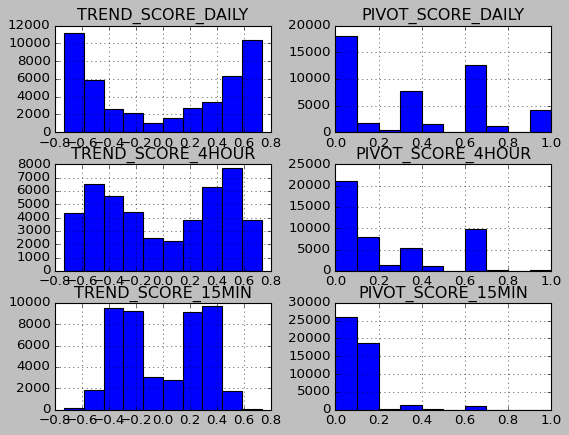

In [22]:
df_result_is[['TREND_SCORE_DAILY', 'PIVOT_SCORE_DAILY', 
              'TREND_SCORE_4HOUR', 'PIVOT_SCORE_4HOUR', 
              'TREND_SCORE_15MIN', 'PIVOT_SCORE_15MIN']].hist()

array([[<Axes: title={'center': 'ENTRY_BUY_SCORE'}>,
        <Axes: title={'center': 'ENTRY_SELL_SCORE'}>]], dtype=object)

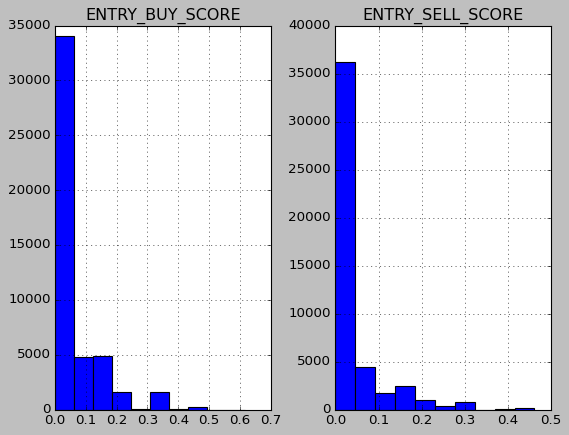

In [23]:
df_result_is[['ENTRY_BUY_SCORE', 'ENTRY_SELL_SCORE']].hist()

### Tuning

In [ ]:
new_config = {
    'RSI_PARAMS': {'INPUT_PARAM': 7, 'CUTOFF_BUY': 30, 'CUTOFF_SELL': 70},
    'BB_PARAMS': {'INPUT_MEAN': 50, 'INPUT_SD': 2, 'BB_CUTOFF': 3},
    'EMA_1_PARAMS': {'INPUT_PARAM': 50},
    'EMA_2_PARAMS': {'INPUT_PARAM': 200},
    'WEIGHT_DAILY': 3,
    'WEIGHT_4HOUR': 2,
    'WEIGHT_15MIN': 2,
    'LOOKBACK': 20,
    'base_SL': 10, 
    'base_TP': 20,
    'DECISION_CUTOFF': {'ENTRY_BUY_CUTOFF': 0.02, 'ENTRY_SELL_CUTOFF': 0.02}
}

In [ ]:
def _TA_strat_v1_test(row):
    RSI_PARAMS = new_config['RSI_PARAMS']
    BB_PARAMS = new_config['BB_PARAMS']
    EMA_1_PARAMS = new_config['EMA_1_PARAMS']
    EMA_2_PARAMS = new_config['EMA_2_PARAMS']
    WEIGHT_DAILY = new_config['WEIGHT_DAILY']
    WEIGHT_4HOUR = new_config['WEIGHT_4HOUR']
    WEIGHT_15MIN = new_config['WEIGHT_15MIN']
    base_SL = new_config['base_SL']
    base_TP = new_config['base_TP']
    DECISION_CUTOFF = new_config['DECISION_CUTOFF']
    
    entry_buy_score = (
            (row['TREND_SCORE_DAILY'] > 0.3) * WEIGHT_DAILY + \
            ((row['TREND_SCORE_DAILY'] < -0.3) & (row['PIVOT_SCORE_DAILY'] > 0.3)) * WEIGHT_DAILY + \
            (row['TREND_SCORE_4HOUR'] > 0.2) * WEIGHT_4HOUR + \
            ((row['TREND_SCORE_4HOUR'] < -0.2) & (row['PIVOT_SCORE_4HOUR'] > 0.2)) * WEIGHT_4HOUR + \
            (row['TREND_SCORE_15MIN'] > 0) * WEIGHT_15MIN + \
            1
        ) * \
        (
            (row['RSI'] < RSI_PARAMS['CUTOFF_BUY']) + \
            (
                (row['CLOSE'] <= row[f'EMA({EMA_1_PARAMS["INPUT_PARAM"]})']) & \
                (row['CLOSE'] >= row[f'EMA({EMA_2_PARAMS["INPUT_PARAM"]})'])
            ) + \
            (np.abs(row['CLOSE'] - row[f'BB_LOWER_BAND({BB_PARAMS["INPUT_MEAN"]})']) < BB_PARAMS['BB_CUTOFF']) 
        )

    entry_buy_score /= (2*WEIGHT_DAILY + 2*WEIGHT_4HOUR + WEIGHT_15MIN + 1)*(3)

    entry_sell_score = (
            (row['TREND_SCORE_DAILY'] < -0.3) * WEIGHT_DAILY + \
            ((row['TREND_SCORE_DAILY'] > 0.3) & (row['PIVOT_SCORE_DAILY'] > 0.3)) * WEIGHT_DAILY + \
            (row['TREND_SCORE_4HOUR'] < -0.2) * WEIGHT_4HOUR + \
            ((row['TREND_SCORE_4HOUR'] > 0.2) & (row['PIVOT_SCORE_4HOUR'] > 0.2)) * WEIGHT_4HOUR + \
            (row['TREND_SCORE_15MIN'] < 0) * WEIGHT_15MIN + \
            1
        ) * \
        (
            (row['RSI'] > RSI_PARAMS['CUTOFF_SELL']) + \
            (
                (row['CLOSE'] >= row[f'EMA({EMA_1_PARAMS["INPUT_PARAM"]})']) & \
                (row['CLOSE'] <= row[f'EMA({EMA_2_PARAMS["INPUT_PARAM"]})'])
            ) + \
            (np.abs(row['CLOSE'] - row[f'BB_UPPER_BAND({BB_PARAMS["INPUT_MEAN"]})']) < BB_PARAMS['BB_CUTOFF']) 
        )

    entry_sell_score /= (2*WEIGHT_DAILY + 2*WEIGHT_4HOUR + WEIGHT_15MIN + 1)*(3)
    
    signal = 0
    if ((entry_buy_score > DECISION_CUTOFF['ENTRY_BUY_CUTOFF']) & (entry_buy_score > entry_sell_score)):
        signal = 1
        SL = base_SL
        TP = base_TP
    elif ((entry_sell_score > DECISION_CUTOFF['ENTRY_SELL_CUTOFF']) & (entry_sell_score > entry_buy_score)):
        signal = -1
        SL = base_SL
        TP = base_TP
    else: 
        signal = 0
        SL = 0
        TP = 0
    

    return(pd.Series([
                    entry_buy_score, 
                    entry_sell_score,
                    signal,
                    SL,
                    TP
                    ], 
                    index = [
                        'ENTRY_BUY_SCORE',
                        'ENTRY_SELL_SCORE',
                        'SIGNAL', 
                        'SL',
                        'TP'
                    ]))


In [ ]:
new_signal = df_result_is.apply(_TA_strat_v1_test, axis = 1)

In [ ]:
new_signal[['ENTRY_BUY_SCORE', 'ENTRY_SELL_SCORE']].hist()

## Out-sample test

In [ ]:
cnt = 0

while cnt <= 10:
    print('='*100)
    print(cnt)
    print('='*100)
    id = random.randint(0, df_15_min_os.shape[0])
    report_os = Backtest_report(alpha = alpha,
                                df_is = df_15_min_os[id - 50: id + 5000].copy(),
                                base_SL = 10,
                                base_TP = 20,
                                max_existing_positions = 5,
                                init_vol = 0.01,
                                re_allocation = True,
                                incre_vol = 0.01,
                                max_vol = 0.1,
                                init_cap = 1000,
                                incre_cap = 2
                                )

    report_os.display_report()
    cnt += 1

In [ ]:
pd.concat(
    [
        pd.pivot_table(
            report_os.df_result_is[(report_os.df_result_is['FLAG_VALID_POSITION'] == 1) & (report_os.df_result_is['SIGNAL'] != 0) & (report_os.df_result_is['PNL'] > 0)],
            index = 'SIGNAL',
            values = 'CLOSE_open',
            aggfunc = 'count',
            margins = True
        ),
        pd.pivot_table(
            report_os.df_result_is[(report_os.df_result_is['FLAG_VALID_POSITION'] == 1) & (report_os.df_result_is['SIGNAL'] != 0) & (report_os.df_result_is['PNL'] < 0)],
            index = 'SIGNAL',
            values = 'CLOSE_open',
            aggfunc = 'count',
            margins = True
        )
    ],
    axis = 1
)

In [ ]:
df_summary = pd.concat(
    [
        pd.pivot_table(
            report_os.df_result_is[(report_os.df_result_is['FLAG_VALID_POSITION'] == 1) & (report_os.df_result_is['SIGNAL'] != 0) & (report_os.df_result_is['PNL'] > 0)],
            index = 'SIGNAL',
            values = 'CLOSE_open',
            aggfunc = 'count',
            margins = True
        ),
        pd.pivot_table(
            report_os.df_result_is[(report_os.df_result_is['FLAG_VALID_POSITION'] == 1) & (report_os.df_result_is['SIGNAL'] != 0) & (report_os.df_result_is['PNL'] < 0)],
            index = 'SIGNAL',
            values = 'CLOSE_open',
            aggfunc = 'count',
            margins = True
        )
    ],
    axis = 1
)

df_summary.columns = ['WINNING_POSITIONS', 'LOSING_POSITIONS']
df_summary.index = ['SHORT', 'LONG', 'ALL']
df_summary = df_summary.fillna(0)
df_summary['TOTAL_POSITIONS'] = df_summary['WINNING_POSITIONS'] + df_summary['LOSING_POSITIONS']

In [ ]:
df_summary